In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [3]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

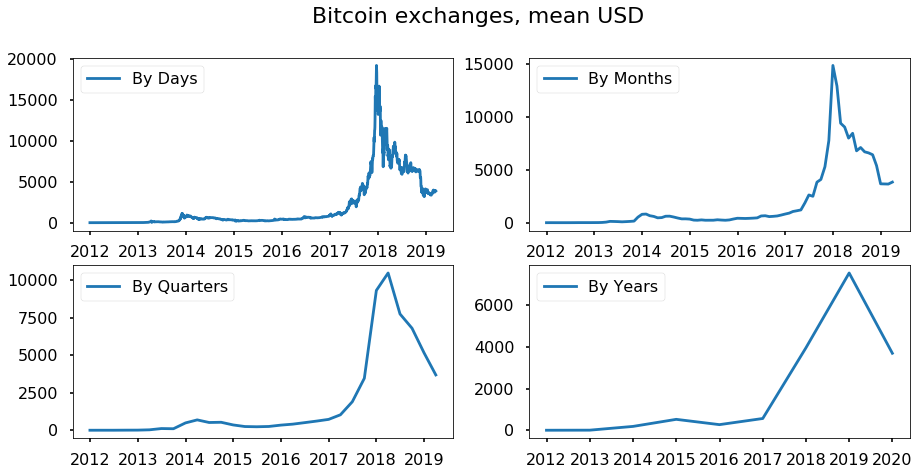

In [5]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.362693


<Figure size 1080x504 with 0 Axes>

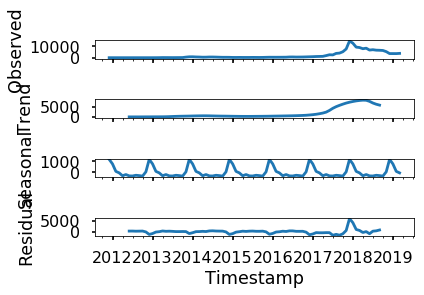

In [6]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [7]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.362693


In [8]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.273352


Dickey–Fuller test: p=0.000030


<Figure size 1080x504 with 0 Axes>

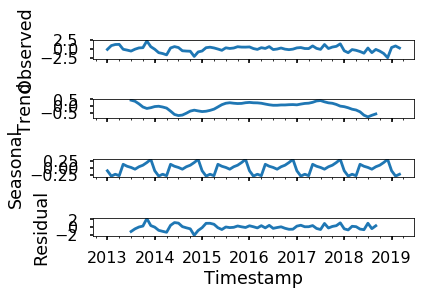

In [9]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

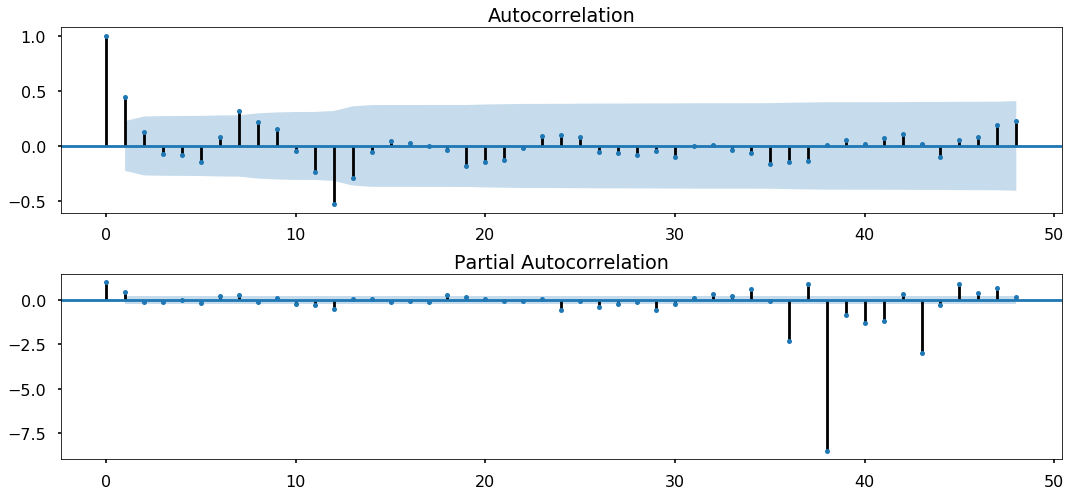

In [10]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [11]:
df_month.Weighted_Price_box

Timestamp
2011-12-31     1.616973
2012-01-31     2.005152
2012-02-29     1.805755
2012-03-31     1.738675
2012-04-30     1.742112
2012-05-31     1.757335
2012-06-30     1.958359
2012-07-31     2.282009
2012-08-31     2.703584
2012-09-30     2.760037
2012-10-31     2.780725
2012-11-30     2.750419
2012-12-31     2.943130
2013-01-31     3.142509
2013-02-28     3.848279
2013-03-31     4.999393
2013-04-30     6.259309
2013-05-31     6.127452
2013-06-30     5.948421
2013-07-31     5.614823
2013-08-31     5.917950
2013-09-30     6.220859
2013-10-31     6.552903
2013-11-30     8.749795
2013-12-31     9.533498
2014-01-31     9.594068
2014-02-28     9.184940
2014-03-31     8.973440
2014-04-30     8.499845
2014-05-31     8.592166
                ...    
2016-10-31     9.111747
2016-11-30     9.350354
2016-12-31     9.597063
2017-01-31     9.800183
2017-02-28    10.107948
2017-03-31    10.241899
2017-04-30    10.375077
2017-05-31    11.298472
2017-06-30    12.023038
2017-07-31    11.915241
2017-0

In [12]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)


In [13]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
21  (1, 0, 1, 1)  118.068188
9   (0, 1, 1, 1)  119.846605
23  (1, 0, 2, 1)  120.019958
39  (2, 0, 1, 1)  120.046763
27  (1, 1, 1, 1)  120.048287
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                   88
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 -55.034
Date:                            Wed, 24 Apr 2019   AIC                            118.068
Time:                                    17:49:37   BIC                            127.338
Sample:                                12-31-2011   HQIC                           121.770
                                     - 03-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


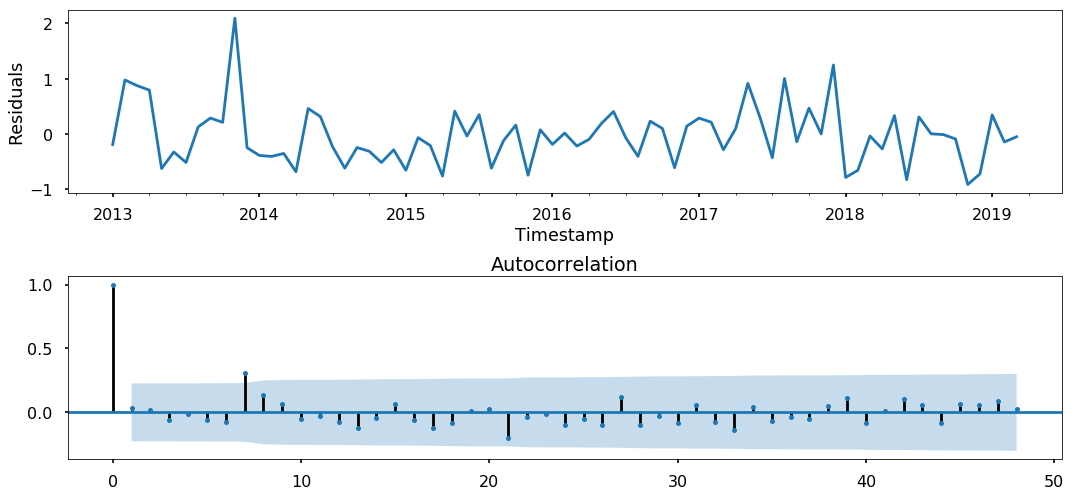

In [15]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [16]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [17]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2019, 4, 30), datetime(2019, 5, 31), datetime(2019, 6, 30), datetime(2019, 7, 31), 
             datetime(2019, 8, 31), datetime(2019, 9, 30), datetime(2019, 10, 31), datetime(2019, 11, 30),
             datetime(2019, 12, 31)
             ]
df_month

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
Timestamp,,,,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,1.616973,NaN,NaN
2012-01-31,6.208043,6.210657,6.205760,6.208932,5.411459,32.615170,6.208550,2.005152,NaN,NaN
2012-02-29,5.253117,5.255079,5.250537,5.252514,8.398000,43.115105,5.252527,1.805755,NaN,NaN
2012-03-31,4.963496,4.964408,4.960139,4.961054,15.830074,78.996873,4.962021,1.738675,NaN,NaN
2012-04-30,4.976732,4.978059,4.975054,4.976416,19.889152,98.856816,4.976547,1.742112,NaN,NaN
2012-05-31,5.041520,5.041904,5.040797,5.041147,21.497513,108.322552,5.041348,1.757335,NaN,NaN
2012-06-30,5.971076,5.972650,5.969648,5.971215,27.350580,167.318899,5.971145,1.958359,NaN,NaN
2012-07-31,7.795111,7.797907,7.792536,7.795285,20.043969,155.583439,7.795287,2.282009,NaN,NaN
2012-08-31,10.917768,10.923414,10.910974,10.916212,20.560617,221.025896,10.917100,2.703584,NaN,NaN


In [18]:
future = pd.DataFrame(index=date_list, columns= df_month.columns)
future

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
2019-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:

df_month2 = pd.concat([df_month, future])
df_month2

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box,prices_box_diff,prices_box_diff2
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,1.616973,NaN,NaN
2012-01-31,6.208043,6.210657,6.205760,6.208932,5.411459,32.615170,6.208550,2.005152,NaN,NaN
2012-02-29,5.253117,5.255079,5.250537,5.252514,8.398000,43.115105,5.252527,1.805755,NaN,NaN
2012-03-31,4.963496,4.964408,4.960139,4.961054,15.830074,78.996873,4.962021,1.738675,NaN,NaN
2012-04-30,4.976732,4.978059,4.975054,4.976416,19.889152,98.856816,4.976547,1.742112,NaN,NaN
2012-05-31,5.041520,5.041904,5.040797,5.041147,21.497513,108.322552,5.041348,1.757335,NaN,NaN
2012-06-30,5.971076,5.972650,5.969648,5.971215,27.350580,167.318899,5.971145,1.958359,NaN,NaN
2012-07-31,7.795111,7.797907,7.792536,7.795285,20.043969,155.583439,7.795287,2.282009,NaN,NaN
2012-08-31,10.917768,10.923414,10.910974,10.916212,20.560617,221.025896,10.917100,2.703584,NaN,NaN
2012-09-30,11.410774,11.413406,11.408130,11.410782,16.646623,188.022224,11.410971,2.760037,NaN,NaN


In [20]:
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=97), lmbda)
df_month2['forecast']

2011-12-31        1.000000
2012-01-31        4.471604
2012-02-29        6.208551
2012-03-31        5.252527
2012-04-30        4.962021
2012-05-31        4.976547
2012-06-30        5.041348
2012-07-31        5.971145
2012-08-31        7.795288
2012-09-30       10.917100
2012-10-31       11.410971
2012-11-30       11.596921
2012-12-31       20.912958
2013-01-31       17.663857
2013-02-28       12.445750
2013-03-31       31.432533
2013-04-30       77.593789
2013-05-31      171.984113
2013-06-30      128.887437
2013-07-31      117.926654
2013-08-31       95.358609
2013-09-30      104.367049
2013-10-31      134.352926
2013-11-30      162.451819
2013-12-31      900.189111
2014-01-31      994.606950
2014-02-28      817.294396
2014-03-31      713.552768
2014-04-30      662.878795
2014-05-31      378.144154
                  ...     
2018-04-30     8894.079564
2018-05-31     7376.226276
2018-06-30     9459.591258
2018-07-31     6249.147279
2018-08-31     6678.946109
2018-09-30     6613.802352
2

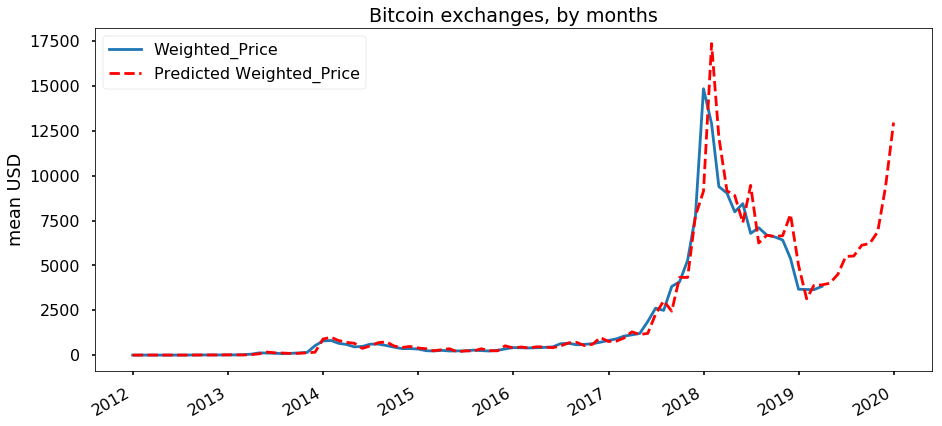

In [28]:
# Prediction


plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()

df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

